In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.exceptions.ComplexWarning) #flavio creates a ComplexWarning each time it computes the CKM elements

from formulas.alp_decays import *
from formulas.meson_semilep_decays import *
from formulas.meson_leptonic import BR_Bs_int, BR_Bs_quad, BR_KL_quad
from formulas.constants import *
from formulas.exp_limits import *

from scipy.interpolate import SmoothBivariateSpline
import pandas as pd

plt.rcParams.update({'text.usetex':True}) # Nicer looking plots with proper TeX rendering

/home/jorge/.local/lib/python3.12/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


In [2]:
import yaml

with open('data/BR.yaml', 'rt') as f:
    data_BR = yaml.safe_load(f)

def parse_value(v):
    v_parts = v.split(' ')
    central = float(v_parts[0])
    exponent = int(v_parts[-1][-1])
    unc = []
    for p in v_parts[1:-1]:
        if p != '±':
            unc.append(float(p))
    unc_tot = sum(u**2 for u in unc)**0.5
    return (central*10**(-exponent), unc_tot*10**(-exponent))

In [3]:
bins_x_LHCb = []
bins_uncx_LHCb = []
bins_y_LHCb = []
bins_uncy_LHCb = []
flavio_y_LHCb = []
flavio_uncy_LHCb = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for v in data_BR['CMS2024']['values']:
        q2min = v['q2min']
        q2max = v['q2max']
        bins_x_LHCb.append((q2min+q2max)/2)
        bins_uncx_LHCb.append((q2max-q2min)/2)
        cent, unc = parse_value(v['value'])
        bins_y_LHCb.append(cent)
        bins_uncy_LHCb.append(unc)
        #flavio_y_LHCb.append(flavio.sm_prediction('<dBR/dq2>(B+->Kmumu)', q2min, q2max))
        #flavio_uncy_LHCb.append(flavio.sm_uncertainty('<dBR/dq2>(B+->Kmumu)', q2min, q2max))

<ErrorbarContainer object of 3 artists>

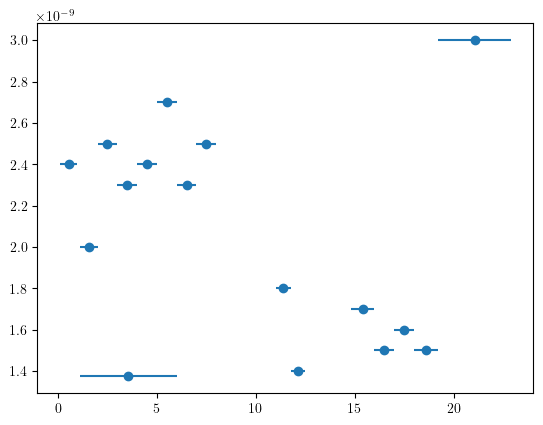

In [4]:
plt.errorbar(bins_x_LHCb, bins_uncy_LHCb, xerr=bins_uncx_LHCb, fmt='o')

# $c_{a\Phi}$ ($c_W = c_B = 0$)

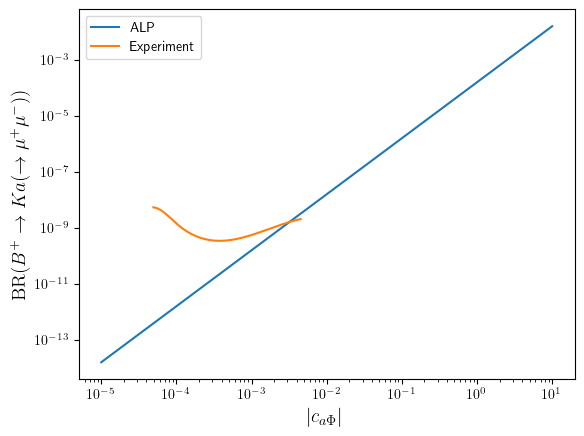

In [5]:
plt.loglog([10**x for x in np.linspace(-5, 1, 200)], [BR_BKmumu(2.5, {'caPhi': 10**x}) for x in np.linspace(-5, 1, 200)], label='ALP')
plt.loglog([10**x for x in np.linspace(-5, 1, 200)], [lim_BKmumu_LHCb(2.5, {'caPhi': 10**x}) for x in np.linspace(-5, 1, 200)], label='Experiment')
plt.xlabel(r'$|c_{a\Phi}|$', fontsize=14)
plt.ylabel(r'$\mathrm{BR}(B^+ \to K a (\to \mu^+\mu^-))$', fontsize=14)
plt.legend()

In [6]:
lim_sup_BKmumu = []
lim_inf_BKmumu = []
for ma in np.linspace(0.2535545, 4.69668246, 200):
    excl_inf = float('inf')
    excl_sup = float('-inf')
    for c in [10**x for x in np.linspace(-5, 1, 500)]:
        br_alp = BR_BKmumu(ma, {'caPhi': c})
        br_exp = lim_BKmumu_LHCb(ma, {'caPhi': c})
        if (not np.isnan(br_exp)) and br_alp > br_exp:
            excl_inf = min(excl_inf, c)
            excl_sup = max(excl_sup, c)
    if np.isfinite(excl_sup):
        lim_inf_BKmumu.append(max(excl_inf, (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/1e3)**0.5))
    else:
        lim_inf_BKmumu.append(float('nan'))
    if np.isfinite(excl_sup):
        lim_sup_BKmumu.append(min(excl_sup, (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/1e-1)**0.5))
    else:
        lim_sup_BKmumu.append(float('nan'))
    if lim_sup_BKmumu[-1] < lim_inf_BKmumu[-1]:
        lim_sup_BKmumu[-1] = float('nan')
        lim_inf_BKmumu[-1] = float('nan')

Text(0, 0.5, '$\\Gamma_a$ [GeV]')

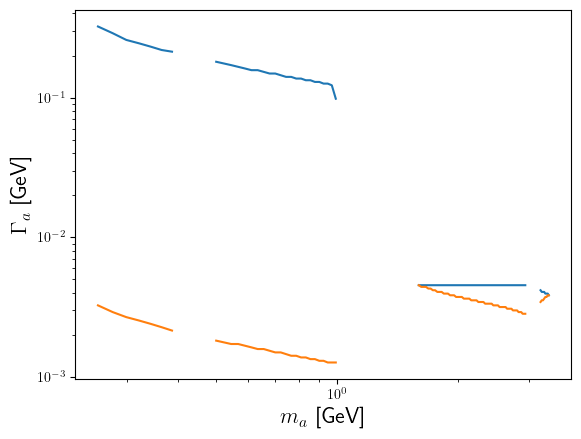

In [7]:
plt.loglog(np.linspace(0.2535545, 4.69668246, 200), lim_sup_BKmumu)
plt.loglog(np.linspace(0.2535545, 4.69668246, 200), lim_inf_BKmumu)
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$\Gamma_a$ [GeV]', fontsize=16)

Text(0, 0.5, '$\\tau$ [ps]')

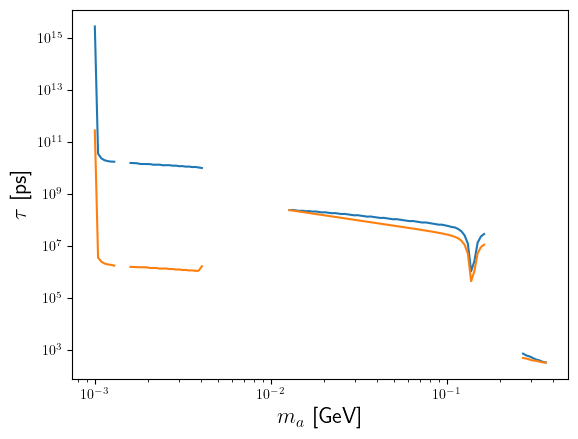

In [8]:
plt.loglog([10**x for x in np.linspace(-3, np.log10(4.65), 200)], [hbar_GeVps/Gamma_a_tot(10**x, {'caPhi': c}) for x, c in zip(np.linspace(-3, np.log10(4.65), 200), lim_inf_BKmumu)])
plt.loglog([10**x for x in np.linspace(-3, np.log10(4.65), 200)], [hbar_GeVps/Gamma_a_tot(10**x, {'caPhi': c}) for x, c in zip(np.linspace(-3, np.log10(4.65), 200), lim_sup_BKmumu)])
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$\tau$ [ps]', fontsize=16)

In [9]:
from scipy.interpolate import SmoothBivariateSpline
import pandas as pd

In [10]:
df_1ns = pd.read_csv('data/Kpimumu_1ns.csv', names=['ma_MeV', 'br']).drop_duplicates('ma_MeV').sort_values(by = 'ma_MeV')
df_100ps = pd.read_csv('data/Kpimumu_100ps.csv', names=['ma_MeV', 'br']).drop_duplicates('ma_MeV').sort_values(by = 'ma_MeV')
df_10ns = pd.read_csv('data/Kpimumu_10ns.csv', names=['ma_MeV', 'br']).drop_duplicates('ma_MeV').sort_values(by = 'ma_MeV')
df_100ns = pd.read_csv('data/Kpimumu_100ns.csv', names=['ma_MeV', 'br']).drop_duplicates('ma_MeV').sort_values(by = 'ma_MeV')
df_10ps = pd.read_csv('data/Kpimumu_10ps.csv', names=['ma_MeV', 'br']).drop_duplicates('ma_MeV').sort_values(by = 'ma_MeV')

In [11]:
ma_Kpimumu = sorted(list(set(df_10ns['ma_MeV']) & set(df_100ns['ma_MeV']) & set(df_100ps['ma_MeV']) & set(df_10ps['ma_MeV']) & set(df_1ns['ma_MeV'])))

In [12]:
ma0_Kpimumu = []
logtau_Kpimuumu = []
logbr_Kpimumu = []
for ma in ma_Kpimumu:
    ma0_Kpimumu.append(ma/1000)
    logtau_Kpimuumu.append(1)
    logbr_Kpimumu.append(np.log10(float(df_10ps.loc[df_10ps['ma_MeV']==ma]['br'])))
    ma0_Kpimumu.append(ma/1000)
    logtau_Kpimuumu.append(2)
    logbr_Kpimumu.append(np.log10(float(df_100ps.loc[df_100ps['ma_MeV']==ma]['br'])))
    ma0_Kpimumu.append(ma/1000)
    logtau_Kpimuumu.append(3)
    logbr_Kpimumu.append(np.log10(float(df_1ns.loc[df_1ns['ma_MeV']==ma]['br'])))
    ma0_Kpimumu.append(ma/1000)
    logtau_Kpimuumu.append(4)
    logbr_Kpimumu.append(np.log10(float(df_10ns.loc[df_10ns['ma_MeV']==ma]['br'])))
    ma0_Kpimumu.append(ma/1000)
    logtau_Kpimuumu.append(5)
    logbr_Kpimumu.append(np.log10(float(df_100ns.loc[df_100ns['ma_MeV']==ma]['br'])))

interp_Kpimumu = SmoothBivariateSpline(ma0_Kpimumu, logtau_Kpimuumu, logbr_Kpimumu)

/tmp/ipykernel_80095/2738289822.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  logbr_Kpimumu.append(np.log10(float(df_10ps.loc[df_10ps['ma_MeV']==ma]['br'])))
/tmp/ipykernel_80095/2738289822.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  logbr_Kpimumu.append(np.log10(float(df_100ps.loc[df_100ps['ma_MeV']==ma]['br'])))
/tmp/ipykernel_80095/2738289822.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  logbr_Kpimumu.append(np.log10(float(df_1ns.loc[df_1ns['ma_MeV']==ma]['br'])))
/tmp/ipykernel_80095/2738289822.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  logbr_Kpimumu.append(np.l

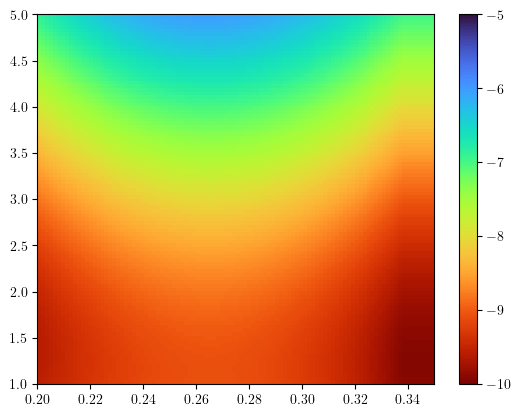

In [13]:
plt.imshow(np.flip(interp_Kpimumu(np.linspace(0.2, 0.35, 100), np.linspace(1, 5, 100)).T), cmap='turbo_r', vmin=-10, vmax=-5, extent=[0.2, 0.35,1,5], aspect='auto')
plt.colorbar()

In [14]:
lim_sup_Kpimumu = []
lim_inf_Kpimumu = []
for ma in np.linspace(min(ma_Kpimumu)/1000, max(ma_Kpimumu)/1000, 200):
    
    excl_inf = float('inf')
    excl_sup = float('-inf')
    #excl_inf = (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/10)**0.5
    #excl_sup = (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/1e5)**0.5
    for c in [10**x for x in np.linspace(-5, 1, 500)]:
        br_alp = np.log10(BR_Kpimumu(ma, {'caPhi': c}))
        tau = np.log10(hbar_GeVps/Gamma_a_tot(ma, {'caPhi': c}))
        br_exp = interp_Kpimumu(ma, tau)
        if (not np.isnan(br_exp)) and br_alp > br_exp:
            excl_inf = min(excl_inf, c)
            excl_sup = max(excl_sup, c)
    if np.isfinite(excl_inf):
        lim_inf_Kpimumu.append(max(excl_inf, (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/1e5)**0.5))
    else:
        lim_inf_Kpimumu.append(float('nan'))
    if np.isfinite(excl_sup):
        lim_sup_Kpimumu.append(min(excl_sup, (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/10)**0.5))
    else:
        lim_sup_Kpimumu.append(float('nan'))

In [15]:
df_BKstar = pd.read_csv('data/lhcbkstar.txt', sep=' ', names=['ma_MeV', 'tau', 'br'])
df_BKstar = df_BKstar.loc[df_BKstar['br'] < 1e-6]
br_BKstar_interp = SmoothBivariateSpline(df_BKstar['ma_MeV']/1000, np.log10(df_BKstar['tau']), np.log10(df_BKstar['br']), s=0.01*len(df_BKstar['ma_MeV']))
def br_BKstarmumu_exp(ma, logtau):
    if ma > 2.896090 and ma < 3.21804:
        return float('nan')
    if ma > 3.57578 and ma < 3.91390:
        return float('nan')
    if ma > 0.746833 and ma < 0.817453 and logtau < 0:
        return float('nan')
    if ma > 1.0093 and ma < 1.02462 and logtau < 0:
        return float('nan')
        
    return br_BKstar_interp(ma, logtau)

In [16]:
import flavio
A0_BKst = lambda q2: flavio.physics.bdecays.formfactors.b_v.bsz.ff('B->K*', q2, pars)['A0']
def BR_B0Ksta(ma, couplings, f_a=1000):
    return mB0**3*abs(gq_eff('bs', couplings, f_a))**2/(64*np.pi) * A0_BKst(ma**2)**2*np.sqrt(kallen(1, mKst0**2/mB0**2, ma**2/mB0**2))**3/GammaB0

def BR_B0Kstmumu(ma, couplings, f_a=1000):
    return BR_B0Ksta(ma, couplings, f_a=1000) * BR_amu(ma, couplings, f_a=1000)

lim_sup_BKstmumu = []
lim_inf_BKstmumu = []
for ma in np.linspace(0.214, 4.349, 200):
    excl_inf = float('inf')
    excl_sup = float('-inf')
    for c in [10**x for x in np.linspace(-5, 1, 500)]:
        br_alp = np.log10(BR_B0Kstmumu(ma, {'caPhi': c}))
        tau = np.log10(hbar_GeVps/Gamma_a_tot(ma, {'caPhi': c}))
        br_exp = br_BKstarmumu_exp(ma, tau)
        if (not np.isnan(br_exp)) and br_alp > br_exp:
            excl_inf = min(excl_inf, c)
            excl_sup = max(excl_sup, c)
    if np.isfinite(excl_inf):
        lim_inf_BKstmumu.append(max(excl_inf, (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/1e3)**0.5))
    else:
        lim_inf_BKstmumu.append(float('nan'))
    if np.isfinite(excl_sup):
        lim_sup_BKstmumu.append(min(excl_sup, (hbar_GeVps/Gamma_a_tot(ma, {'caPhi': 1})/1e-1)**0.5))
    else:
        lim_sup_BKstmumu.append(float('nan'))
    if lim_sup_BKstmumu[-1] < lim_inf_BKstmumu[-1]:
        lim_sup_BKstmumu[-1] = float('nan')
        lim_inf_BKstmumu[-1] = float('nan')

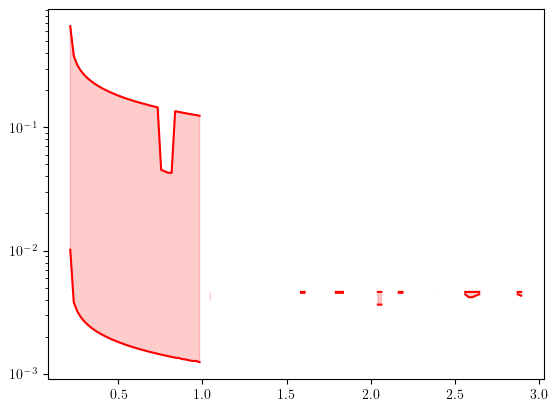

In [17]:

plt.semilogy(np.linspace(0.214, 4.349, 200), lim_sup_BKstmumu, c='red', label=r'$B^+\to K^+\mu^+\mu^-$ (dv)')
plt.semilogy(np.linspace(0.214, 4.349, 200), lim_inf_BKstmumu, c='red')
plt.fill_between(np.linspace(0.214, 4.349, 200), lim_inf_BKstmumu, lim_sup_BKstmumu, color='red', alpha=0.2)

In [18]:
couplings = {'caPhi': 1}

/home/jorge/Documents/GitHub/meson_alps/formulas/alp_decays.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.abs(cll_eff(mferm, couplings, f_a=1000))**2*ma*mferm**2/(8*np.pi*f_a**2)*np.sqrt(1-4*mferm**2/ma**2)
/home/jorge/Documents/GitHub/meson_alps/formulas/alp_decays.py:12: RuntimeWarning: invalid value encountered in sqrt
  g00 = lambda r: 2/(1-r)**2*quad(lambda z: np.sqrt(1-4*r/z)*np.sqrt(kallen(1, z, r)), 4*r, (1-np.sqrt(r))**2)[0]
/home/jorge/Documents/GitHub/meson_alps/formulas/alp_decays.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  g00 = lambda r: 2/(1-r)**2*quad(lambda z: np.sqrt(1-4*r/z)*np.sqrt(kallen(1, z, r)), 4*r, (1-np.sqrt(r))**2)[0]
/home/jorge/Documents/GitHub/meson_alps/formulas/alp_decays.py:19: RuntimeWarning: invalid value encountered in sqrt
  gpm = lambda r: 12/(1-r)**2*quad(lambda z: np.sqrt(1-4*r/z)*np.sqrt(kalle

Text(0.8, 1e-22, '$\\frac{|c_{a\\Phi}|}{f_a} = $ 1 TeV$^{-1}$')

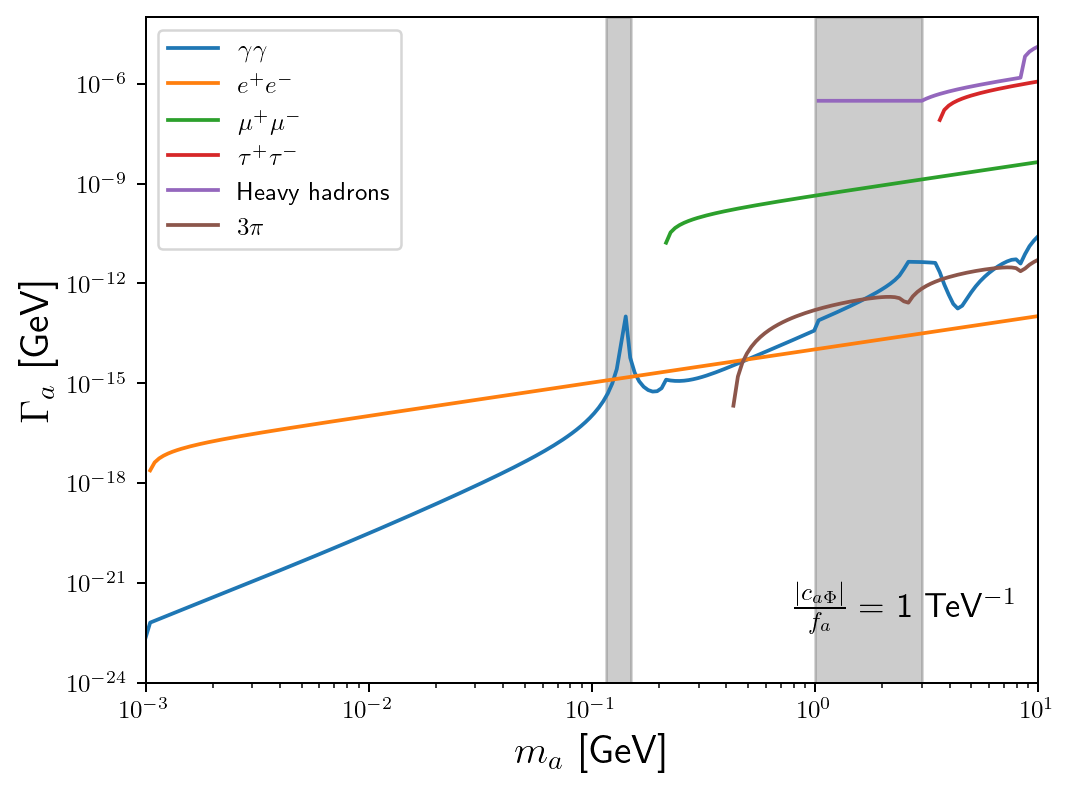

In [19]:
plt.figure(dpi=180)
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_agamma(10**x, couplings) for x in np.linspace(-3, 1, 200)], label=r'$\gamma\gamma$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aferm(10**x, me, couplings) for x in np.linspace(-3, 1, 200)], label=r'$e^+e^-$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aferm(10**x, mmu, couplings) for x in np.linspace(-3, 1, 200)], label=r'$\mu^+\mu^-$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aferm(10**x, mtau, couplings) for x in np.linspace(-3, 1, 200)], label=r'$\tau^+\tau^-$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aheavyq(10**x, couplings) for x in np.linspace(-3, 1, 200)], label='Heavy hadrons')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_3pi0(10**x, couplings)+Gamma_3pipm(10**x, couplings) for x in np.linspace(-3, 1, 200)], label=r'$3\pi$')
plt.fill_betweenx([1e-24, 1e-4], [1, 1], [3, 3], color='k', alpha=0.2)
plt.fill_betweenx([1e-24, 1e-4], [0.115, 0.115], [0.150, 0.150], color='k', alpha=0.2)
plt.ylim(1e-24, 1e-4)
plt.xlim(1e-3, 10)
plt.legend()
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$\Gamma_a$ [GeV]', fontsize=16)
plt.annotate(r'$\frac{|c_{a\Phi}|}{f_a} = $ 1 TeV$^{-1}$', (0.8, 1e-22), fontsize=14)

(1e-09, 1.2)

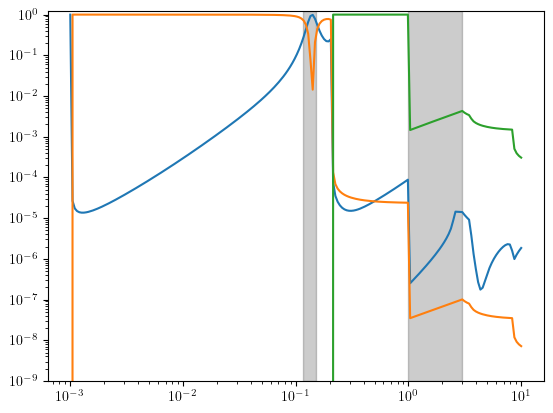

In [20]:
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [BR_agamma(10**x, couplings) for x in np.linspace(-3, 1, 200)])
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [BR_ae(10**x, couplings) for x in np.linspace(-3, 1, 200)])
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [BR_amu(10**x, couplings) for x in np.linspace(-3, 1, 200)])
plt.fill_betweenx([1e-9, 1.2], [1, 1], [3, 3], color='k', alpha=0.2)
plt.fill_betweenx([1e-9, 1.2], [0.115, 0.115], [0.150, 0.150], color='k', alpha=0.2)
plt.ylim(1e-9, 1.2)

In [21]:
Nsigma = 2

ma_err_LHCb = []
c_err_LHCb = []
for i in range(len(data_BR['CMS2024']['values'])):
    if i>=1 and data_BR['CMS2024']['values'][i]['q2min'] != data_BR['CMS2024']['values'][i-1]['q2max']:
        ma_err_LHCb.append(data_BR['CMS2024']['values'][i-1]['q2max']**0.5*1.001)
        ma_err_LHCb.append(data_BR['CMS2024']['values'][i]['q2min']**0.5*0.999)
        c_err_LHCb.append(float('nan'))
        c_err_LHCb.append(float('nan'))
    q2min = data_BR['CMS2024']['values'][i]['q2min']
    q2max = data_BR['CMS2024']['values'][i]['q2max']
    BR_exp_err =  Nsigma*bins_uncy_LHCb[i]
    for ma in np.linspace(q2min**0.5, q2max**0.5, 50):
        deltaBR = BR_BKmumu(ma, couplings)
        ma_err_LHCb.append(ma)
        #c0 = np.sqrt(BR_exp_err/deltaBR)
        #if hbar_GeVps/Gamma_a_tot(ma, {'caPhi': c0}) < 0.1:
        #    c_err_LHCb.append(c0)
        #else:
        c_err_LHCb.append( np.sqrt(hbar_GeVps/(0.1*Gamma_a_tot(ma, {'caPhi': 1.0}) )) )

In [22]:
for b in data_BR['CMS2024']['values']:
    print(f'{b["q2min"]}\t{b["q2max"]}')

1.1	6.0
0.1	0.98
1.1	2.0
2.0	3.0
3.0	4.0
4.0	5.0
5.0	6.0
6.0	7.0
7.0	8.0
11.0	11.8
11.8	12.5
14.82	16.0
16.0	17.0
17.0	18.0
18.0	19.24
19.24	22.9


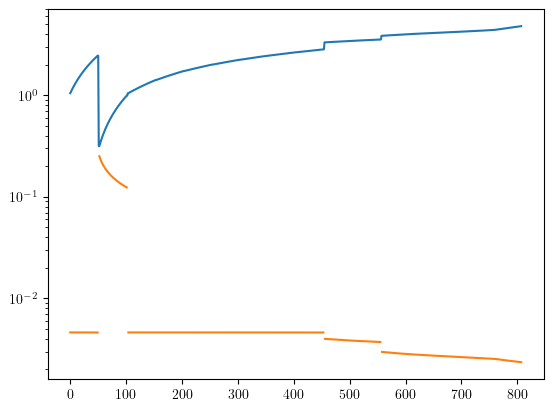

In [23]:
plt.semilogy(ma_err_LHCb)
plt.semilogy(c_err_LHCb)

In [25]:
bka_1p = pd.read_csv('data/BKa_Altmannshofer_1sigma_p.csv')
bka_1m = pd.read_csv('data/BKa_Altmannshofer_1sigma_m.csv')
bka_c = pd.read_csv('data/BKa_Altmannshofer.csv')
bound_bka_1p = [(br/BR_BKa(ma, {'caPhi':1.0}) )**0.5 for br, ma in zip(bka_1p['br'], bka_1p['ma_GeV'])]
bound_bka_1m = [(br/BR_BKa(ma, {'caPhi':1.0}) )**0.5 for br, ma in zip(bka_1m['br'], bka_1m['ma_GeV'])]

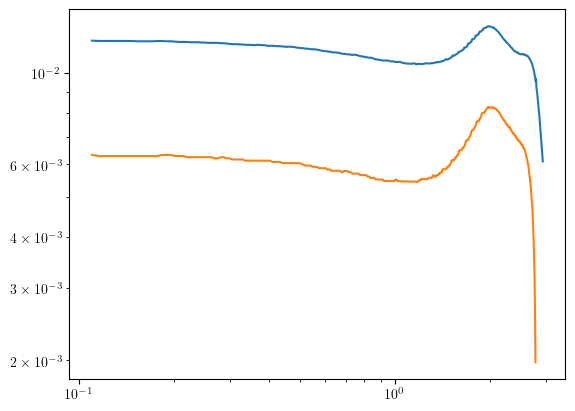

In [26]:
plt.loglog(bka_1p['ma_GeV'], bound_bka_1p)
plt.loglog(bka_1m['ma_GeV'], bound_bka_1m)

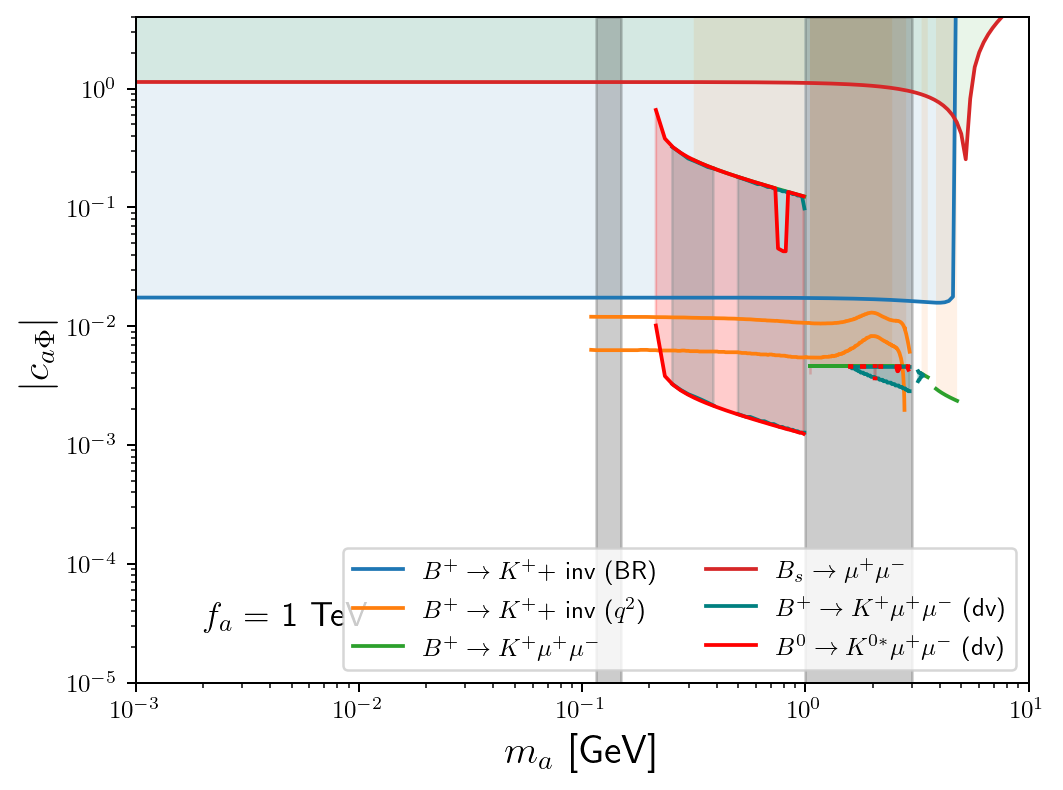

In [28]:
couplings = {'caPhi': 1}
plt.figure(dpi=180)

plt.loglog([10**x for x in np.linspace(-3, np.log10(mB-mK), 200)], [(lim_BKinv/BR_BKa(10**x, couplings))**0.5  for x in np.linspace(-3, np.log10(mB-mK), 200)], label=r'$B^+\to K^+ + $ inv (BR)')
plt.fill_between([10**x for x in np.linspace(-3, np.log10(mB-mK), 200)], [(lim_BKinv/BR_BKa(10**x, couplings))**0.5  for x in np.linspace(-3, np.log10(mB-mK), 200)], 4, alpha=0.1)

plt.loglog(bka_1p['ma_GeV'], bound_bka_1p, label=r'$B^+\to K^+ + $ inv ($q^2$)')
plt.loglog(bka_1m['ma_GeV'], bound_bka_1m, c='tab:orange')
#plt.fill_between(bka_1p['ma_GeV'], bound_bka_1p, bound_bka_1m, alpha=0.2)

plt.loglog(ma_err_LHCb, np.array(c_err_LHCb), label=r'$B^+ \to K^+ \mu^+ \mu^-$')
plt.fill_between(ma_err_LHCb, np.array(c_err_LHCb), 4, alpha=0.1)

#plt.loglog([10**x for x in np.linspace(-2.95, np.log10(0.255), 200)], [(lim_Kpiinv(10**x)/BR_Kpia(10**x, couplings))**0.5  for x in np.linspace(-2.95, np.log10(0.255), 200)], label=r'$K^+ \to \pi^+ +$ inv')
#plt.fill_between([10**x for x in np.linspace(-2.95, np.log10(0.255), 200)], [(lim_Kpiinv(10**x)/BR_Kpia(10**x, couplings))**0.5  for x in np.linspace(-2.95, np.log10(0.255), 200)], 4, alpha=0.1)

#plt.loglog(np.linspace(2*mmu, mK-mpi_pm, 100), [(Nsigma*0.6e-8/(BR_Kpimumu(ma, couplings)))**0.5 for ma in np.linspace(2*mmu, mK-mpi_pm, 100)], label=r'$K^+\to \pi^+\mu^+\mu^-$')
#plt.fill_between(np.linspace(2*mmu, mK-mpi_pm, 100), [(Nsigma*0.6e-8/(BR_Kpimumu(ma, couplings)))**0.5 for ma in np.linspace(2*mmu, mK-mpi_pm, 100)], 4, alpha=0.1)

#plt.loglog([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpiee/(BR_Kpiee(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], label=r'$K^+\to \pi^+e^+e^-$')
#plt.fill_between([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpiee/(BR_Kpiee(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], 4, alpha=0.1)

#plt.loglog([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpigammagamma/(BR_Kpigamma(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], label=r'$K\to \pi\gamma\gamma$')
#plt.fill_between([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpigammagamma/(BR_Kpigamma(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], 4, alpha=0.1)

plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [lim_Bsmumu(10**x, couplings) for x in np.linspace(-3, 1, 200)], label=r'$B_s\to\mu^+\mu^-$')
plt.fill_between([10**x for x in np.linspace(-3, 1, 200)], [lim_Bsmumu(10**x, couplings) for x in np.linspace(-3, 1, 200)], 4, alpha=0.1)

#plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [(lim_KLmumu/BR_KL_quad(10**x, mmu, couplings))**0.25  for x in np.linspace(-3, 1, 200)], label=r'$K_L \to \mu^+\mu^-$')
#plt.fill_between([10**x for x in np.linspace(-3, 1, 200)], [(lim_KLmumu/BR_KL_quad(10**x, mmu, couplings))**0.25  for x in np.linspace(-3, 1, 200)], 4, alpha=0.1)

plt.loglog(np.linspace(0.2535545, 4.69668246, 200), lim_sup_BKmumu, c='teal', label=r'$B^+\to K^+\mu^+\mu^-$ (dv)')
plt.loglog(np.linspace(0.2535545, 4.69668246, 200), lim_inf_BKmumu, c='teal')
plt.fill_between(np.linspace(0.2535545, 4.69668246, 200), lim_inf_BKmumu, lim_sup_BKmumu, color='teal', alpha=0.2)

#plt.loglog(np.linspace(min(ma_Kpimumu)/1000, max(ma_Kpimumu)/1000, 200), lim_inf_Kpimumu, color='purple', label=r'$K^+\to \pi^+\mu^+\mu^-$ (dv)')
#plt.loglog(np.linspace(min(ma_Kpimumu)/1000, max(ma_Kpimumu)/1000, 200), lim_sup_Kpimumu, color='purple')
#plt.fill_between(np.linspace(min(ma_Kpimumu)/1000, max(ma_Kpimumu)/1000, 200), lim_inf_Kpimumu, lim_sup_Kpimumu, color='purple', alpha=0.2)

plt.loglog(np.linspace(0.214, 4.349, 200), lim_sup_BKstmumu, c='red', label=r'$B^0\to K^{0*}\mu^+\mu^-$ (dv)')
plt.loglog(np.linspace(0.214, 4.349, 200), lim_inf_BKstmumu, c='red')
plt.fill_between(np.linspace(0.214, 4.349, 200), lim_inf_BKstmumu, lim_sup_BKstmumu, color='red', alpha=0.2)
plt.ylim(1e-5, 4)
plt.xlim(1e-3, 10)
plt.fill_betweenx([1e-5, 4], [1, 1], [3, 3], color='k', alpha=0.2)
plt.fill_betweenx([1e-5, 4], [0.115, 0.115], [0.150, 0.150], color='k', alpha=0.2)
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$|c_{a\Phi}|$', fontsize=16)
plt.annotate(r'$f_a = $ 1 TeV', (0.2e-2, 0.3e-4), fontsize=14)
plt.legend(loc='lower right', ncols=2)
plt.savefig('plots/mesondecays_caPhi.png')

In [ ]:
couplings = {'caPhi': 1}
plt.figure(dpi=180)

#plt.loglog([10**x for x in np.linspace(-3, np.log10(mB-mK), 200)], [(lim_BKinv/BR_BKa(10**x, couplings))**0.5  for x in np.linspace(-3, np.log10(mB-mK), 200)], label=r'$B^+\to K^+ + $ inv')
#plt.fill_between([10**x for x in np.linspace(-3, np.log10(mB-mK), 200)], [(lim_BKinv/BR_BKa(10**x, couplings))**0.5  for x in np.linspace(-3, np.log10(mB-mK), 200)], 4, alpha=0.1)

#plt.loglog(ma_err_LHCb, np.array(c_err_LHCb), label=r'$B^+ \to K^+ \mu^+ \mu^-$')
#plt.fill_between(ma_err_LHCb, np.array(c_err_LHCb), 4, alpha=0.1)

plt.loglog([10**x for x in np.linspace(-2.95, np.log10(0.255), 200)], [(lim_Kpiinv(10**x)/BR_Kpia(10**x, couplings))**0.5  for x in np.linspace(-2.95, np.log10(0.255), 200)], label=r'$K^+ \to \pi^+ +$ inv')
plt.fill_between([10**x for x in np.linspace(-2.95, np.log10(0.255), 200)], [(lim_Kpiinv(10**x)/BR_Kpia(10**x, couplings))**0.5  for x in np.linspace(-2.95, np.log10(0.255), 200)], 4, alpha=0.1)

plt.loglog(np.linspace(2*mmu, mK-mpi_pm, 100), [(Nsigma*0.6e-8/(BR_Kpimumu(ma, couplings)))**0.5 for ma in np.linspace(2*mmu, mK-mpi_pm, 100)], label=r'$K^+\to \pi^+\mu^+\mu^-$')
plt.fill_between(np.linspace(2*mmu, mK-mpi_pm, 100), [(Nsigma*0.6e-8/(BR_Kpimumu(ma, couplings)))**0.5 for ma in np.linspace(2*mmu, mK-mpi_pm, 100)], 4, alpha=0.1)

plt.loglog([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpiee/(BR_Kpiee(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], label=r'$K^+\to \pi^+e^+e^-$')
plt.fill_between([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpiee/(BR_Kpiee(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], 4, alpha=0.1)

plt.loglog([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpigammagamma/(BR_Kpigamma(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], label=r'$K\to \pi\gamma\gamma$')
plt.fill_between([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpigammagamma/(BR_Kpigamma(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], 4, alpha=0.1)

#plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [lim_Bsmumu(10**x, couplings) for x in np.linspace(-3, 1, 200)], label=r'$B_s\to\mu^+\mu^-$')
#plt.fill_between([10**x for x in np.linspace(-3, 1, 200)], [lim_Bsmumu(10**x, couplings) for x in np.linspace(-3, 1, 200)], 4, alpha=0.1)

plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [(lim_KLmumu/BR_KL_quad(10**x, mmu, couplings))**0.25  for x in np.linspace(-3, 1, 200)], label=r'$K_L \to \mu^+\mu^-$')
plt.fill_between([10**x for x in np.linspace(-3, 1, 200)], [(lim_KLmumu/BR_KL_quad(10**x, mmu, couplings))**0.25  for x in np.linspace(-3, 1, 200)], 4, alpha=0.1)

#plt.loglog(np.linspace(0.2535545, 4.69668246, 200), lim_sup_BKmumu, c='teal', label=r'$B^+\to K^+\mu^+\mu^-$ (dv)')
#plt.loglog(np.linspace(0.2535545, 4.69668246, 200), lim_inf_BKmumu, c='teal')
#plt.fill_between(np.linspace(0.2535545, 4.69668246, 200), lim_inf_BKmumu, lim_sup_BKmumu, color='teal', alpha=0.2)

plt.loglog(np.linspace(min(ma_Kpimumu)/1000, max(ma_Kpimumu)/1000, 200), lim_inf_Kpimumu, color='purple', label=r'$K^+\to \pi^+\mu^+\mu^-$ (dv)')
plt.loglog(np.linspace(min(ma_Kpimumu)/1000, max(ma_Kpimumu)/1000, 200), lim_sup_Kpimumu, color='purple')
plt.fill_between(np.linspace(min(ma_Kpimumu)/1000, max(ma_Kpimumu)/1000, 200), lim_inf_Kpimumu, lim_sup_Kpimumu, color='purple', alpha=0.2)

#plt.loglog(np.linspace(0.214, 4.349, 200), lim_sup_BKstmumu, c='red', label=r'$B^0\to K^{0*}\mu^+\mu^-$ (dv)')
#plt.loglog(np.linspace(0.214, 4.349, 200), lim_inf_BKstmumu, c='red')
#plt.fill_between(np.linspace(0.214, 4.349, 200), lim_inf_BKstmumu, lim_sup_BKstmumu, color='red', alpha=0.2)
plt.ylim(1e-5, 4)
plt.xlim(1e-3, 10)
plt.fill_betweenx([1e-5, 4], [1, 1], [3, 3], color='k', alpha=0.2)
plt.fill_betweenx([1e-5, 4], [0.115, 0.115], [0.150, 0.150], color='k', alpha=0.2)
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$|c_{a\Phi}|$', fontsize=16)
plt.annotate(r'$f_a = $ 1 TeV', (0.2e-2, 0.3e-4), fontsize=14)
plt.legend(loc='lower right', ncols=2)
plt.savefig('plots/mesondecays_caPhi.png')

# $c_W$ ($c_{a\Phi} = c_B = 0$)

In [ ]:
couplings = {'cW': 1}

In [ ]:
plt.figure(dpi=180)
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_agamma(10**x, couplings) for x in np.linspace(-3, 1, 200)], label=r'$\gamma\gamma$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aferm(10**x, me, couplings) for x in np.linspace(-3, 1, 200)], label=r'$e^+e^-$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aferm(10**x, mmu, couplings) for x in np.linspace(-3, 1, 200)], label=r'$\mu^+\mu^-$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aferm(10**x, mtau, couplings) for x in np.linspace(-3, 1, 200)], label=r'$\tau^+\tau^-$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_aheavyq(10**x, couplings) for x in np.linspace(-3, 1, 200)], label='Heavy hadrons')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [Gamma_3pi0(10**x, couplings)+Gamma_3pipm(10**x, couplings) for x in np.linspace(-3, 1, 200)], label=r'$3\pi$')
plt.fill_betweenx([1e-24, 1e-4], [1, 1], [3, 3], color='k', alpha=0.2)
plt.fill_betweenx([1e-24, 1e-4], [0.115, 0.115], [0.150, 0.150], color='k', alpha=0.2)
plt.ylim(1e-24, 1e-4)
plt.xlim(1e-3, 10)
plt.legend()
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$\Gamma_a$ [GeV]', fontsize=16)
plt.annotate(r'$\frac{|c_W|}{f_a} = $ 1 TeV$^{-1}$', (0.8, 1e-22), fontsize=14)

In [ ]:
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [BR_agamma(10**x, couplings) for x in np.linspace(-3, 1, 200)])
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [BR_ae(10**x, couplings) for x in np.linspace(-3, 1, 200)])
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [BR_amu(10**x, couplings) for x in np.linspace(-3, 1, 200)])
plt.fill_betweenx([1e-9, 1.2], [1, 1], [3, 3], color='k', alpha=0.2)
plt.fill_betweenx([1e-9, 1.2], [0.115, 0.115], [0.150, 0.150], color='k', alpha=0.2)
plt.ylim(1e-9, 1.2)

In [ ]:
Nsigma = 2

ma_err_LHCb = []
cW_err_LHCb = []
for i in range(len(data_BR['LHCb2014']['values'])):
    if i>2 and data_BR['LHCb2014']['values'][i]['q2min'] != data_BR['LHCb2014']['values'][i-1]['q2max']:
        ma_err_LHCb.append(data_BR['LHCb2014']['values'][i-1]['q2max']**0.5*1.001)
        ma_err_LHCb.append(data_BR['LHCb2014']['values'][i]['q2min']**0.5*0.999)
        cW_err_LHCb.append(float('nan'))
        cW_err_LHCb.append(float('nan'))
    q2min = data_BR['LHCb2014']['values'][i]['q2min']
    q2max = data_BR['LHCb2014']['values'][i]['q2max']
    BR_exp_err =  Nsigma*bins_uncy_LHCb[i]
    for ma in np.linspace(q2min**0.5, q2max**0.5, 50):
        deltaBR = BR_BKmumu(ma, couplings)
        ma_err_LHCb.append(ma)
        cW_err_LHCb.append(np.sqrt(BR_exp_err/deltaBR))

In [ ]:

plt.figure(dpi=180)
plt.loglog([10**x for x in np.linspace(-3, np.log10(mB-mK), 200)], [(lim_BKinv/BR_BKa(10**x, couplings))**0.5  for x in np.linspace(-3, np.log10(mB-mK), 200)], label=r'$B^+\to K^+ + $ inv')
plt.loglog(ma_err_LHCb, np.sqrt(Nsigma)*np.array(cW_err_LHCb), label=r'$B^+ \to K^+ \mu^+ \mu^-$')
plt.loglog([10**x for x in np.linspace(-2.95, np.log10(0.255), 200)], [(lim_Kpiinv(10**x)/BR_Kpia(10**x, couplings))**0.5  for x in np.linspace(-2.95, np.log10(0.255), 200)], label=r'$K^+ \to \pi^+ +$ inv')
plt.loglog(np.linspace(2*mmu, mK-mpi_pm, 100), [(Nsigma*0.6e-8/(BR_Kpimumu(ma, couplings)))**0.5 for ma in np.linspace(2*mmu, mK-mpi_pm, 100)], label=r'$K^+\to \pi^+\mu^+\mu^-$')
plt.loglog([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpiee/(BR_Kpiee(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], label=r'$K^+\to \pi^+e^+e^-$')
plt.loglog([10**x for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], [(lim_Kpigammagamma/(BR_Kpigamma(10**x, couplings)))**0.5 for x in np.linspace(-3, np.log10(mK-mpi_pm), 100)], label=r'$K\to \pi\gamma\gamma$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [lim_Bsmumu(10**x, couplings) for x in np.linspace(-3, 1, 200)], label=r'$B_s\to\mu^+\mu^-$')
plt.loglog([10**x for x in np.linspace(-3, 1, 200)], [(lim_KLmumu/BR_KL_quad(10**x, mmu, couplings))**0.25  for x in np.linspace(-3, 1, 200)], label=r'$K_L \to \mu^+\mu^-$')
plt.ylim(1e-5, 4)
plt.xlim(1e-3, 10)
plt.fill_betweenx([1e-5, 4], [1, 1], [3, 3], color='k', alpha=0.2)
plt.fill_betweenx([1e-5, 4], [0.115, 0.115], [0.150, 0.150], color='k', alpha=0.2)
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$|c_W|$', fontsize=16)
plt.annotate(r'$f_a = $ 1 TeV', (0.2e-2, 0.3e-4), fontsize=14)
plt.legend(loc='lower right', ncols=2)
plt.savefig('plots/mesondecays_cW.png')

In [ ]:
plt.loglog([10**x for x in np.linspace(-5, 2, 200)], [BR_BKmumu_offshell(10**x, {'caPhi': 1}, 1.1, 6.0) for x in np.linspace(-5, 2, 200)], lw=5)
plt.loglog([10**x for x in np.linspace(-5, 2, 200)], [BR_BKmumu_offshell2(10**x, {'caPhi': 1}, 1.1, 6.0) for x in np.linspace(-5, 2, 200)])

In [ ]:
def BR_BKmumu_offshell2(ma, couplings, q2min, q2max, f_a=1000):
    if ma**2 > q2min and ma**2 < q2max:
        return float('nan')
    integrand = lambda q2: q2*np.sqrt(1-4*mmu**2/q2)*np.sqrt(kallen(mB**2, mK**2, q2))/np.abs(q2-ma**2)**2*f0_BK(q2)**2
    integral = quad(integrand, q2min, q2max)[0]
    return integral*np.abs(gq_eff('bs', couplings, f_a) * cll_eff(mmu, couplings, f_a=1000))**2*mmu**2/f_a**2*(mB**2-mK**2)**2/((2*np.pi)**3*32*mB**3*GammaB)

Nsigma = 2
bound_BKmumu_offshell = np.ones((202))*np.inf
min_q2 = 4*mmu**2
max_q2 = (mB-mK)**2
ma_BKmumu_offshell = [10**x for x in np.linspace(-3, 0.5*np.log10(min_q2), 100)] + [1.01*min_q2**0.5, 0.99*max_q2**0.5] + [10**x for x in np.linspace(0.5*np.log10(max_q2), 1.5, 100)]
for i in range(len(data_BR['CMS2024']['values'])):
    br_exp_err = Nsigma*bins_uncy_LHCb[i]
    for j, ma in enumerate(ma_BKmumu_offshell):
        c = (br_exp_err/BR_BKmumu_offshell2(ma, {'caPhi': 1.0}, data_BR['CMS2024']['values'][i]['q2min'], data_BR['CMS2024']['values'][i]['q2max']))**0.25
        bound_BKmumu_offshell[j] = min(c, bound_BKmumu_offshell[j])

In [ ]:
plt.loglog(ma_BKmumu_offshell, bound_BKmumu_offshell)
plt.loglog(ma_err_LHCb, np.array(c_err_LHCb), label=r'$B^+ \to K^+ \mu^+ \mu^-$')
plt.loglog(np.linspace(0.2535545, 4.69668246, 200), lim_inf_BKmumu, c='teal')
plt.ylim(1e-5, 1e2)

In [ ]:
max(bin['q2max'] for bin in data_BR['CMS2024']['values'])